In [ ]:
! unzip /content/qg_train.zip
! rm /content/qg_train.zip

unzip:  cannot find or open /content/qg_train.zip, /content/qg_train.zip.zip or /content/qg_train.zip.ZIP.
rm: cannot remove '/content/qg_train.zip': No such file or directory


In [ ]:
%pip install transformers
# T5Tokenizer requires the SentencePiece library
%pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install datasets
%pip install rouge_score
%pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing libraries
import os
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Import modules from huggingface
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
OUTPUT_DIR = "./outputs/"
if not os.path.exists(OUTPUT_DIR):
  os.mkdir(OUTPUT_DIR)

# define logging

LOG_FILE = OUTPUT_DIR + f"t5_finetuning_{np.datetime64('now')}"
logging.basicConfig(filename=LOG_FILE, filemode="w", level=logging.DEBUG)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Load data

In [ ]:
INPUT_DIR = "./data/"
train_df = pd.read_csv(INPUT_DIR+"qg_train.csv")
dev_df = pd.read_csv(INPUT_DIR+"qg_dev.csv")

In [ ]:
# for question generation task, prepend answer to sentence
train_df["input"] = "answer: "+train_df["answer"]+" context: "+train_df["context"]
dev_df["input"] = "answer: "+dev_df["answer"]+" context: "+dev_df["context"]

In [ ]:
train_df.head()

,question,answer,sentence,context,input
0,When did Beyonce start becoming popular?,in the late 1990s,"Born and raised in Houston, Texas, she perform...",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,answer: in the late 1990s context: Beyoncé Gis...
1,What areas did Beyonce compete in when she was...,singing and dancing,"Born and raised in Houston, Texas, she perform...",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,answer: singing and dancing context: Beyoncé G...
2,When did Beyonce leave Destiny's Child and bec...,2003,Their hiatus saw the release of Beyoncé's debu...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,answer: 2003 context: Beyoncé Giselle Knowles-...
3,In what city and state did Beyonce grow up?,"Houston, Texas","Born and raised in Houston, Texas, she perform...",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"answer: Houston, Texas context: Beyoncé Gisell..."
4,In which decade did Beyonce become famous?,late 1990s,"Born and raised in Houston, Texas, she perform...",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,answer: late 1990s context: Beyoncé Giselle Kn...


In [ ]:
logging.info(f"[Data]: Reading data...\n")

source_text = "input"
target_text = "question"

train_dataset = train_df.reset_index()[[source_text,target_text]]
test_dataset = dev_df.reset_index()[[source_text,target_text]]

# train test split 
# SQuaD 2.0 train --> 80% train + 20% val
# SQuaD 2.0 dev --> test
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

# reset dataframe index
train_dataset.reset_index(inplace=True)
val_dataset.reset_index(inplace=True)
test_dataset.reset_index(inplace=True)

print(f"Training {train_dataset.shape} samples")
print(f"Validation {val_dataset.shape} samples")
print(f"Test {test_dataset.shape} samples")

Training (69247, 3) samples
Validation (17312, 3) samples
Test (5920, 3) samples


### Define dataset class and functions

In [ ]:
class QuestionSentenceDataset(Dataset):
  """
  Creating a custom dataset 
  """

  def __init__(self, data, tokenizer, source_len, target_len, source_text, target_text):
    self.tokenizer = tokenizer
    self.data = data
    self.source_len = source_len
    self.out_len = target_len
    self.target_text = self.data[target_text]
    self.source_text = self.data[source_text]

  def __len__(self):
    return len(self.target_text)

  def __getitem__(self, index):
    source_text = str(self.source_text[index])
    target_text = str(self.target_text[index])
    
    source_text = ' '.join(source_text.split())
    target_text = ' '.join(target_text.split())

    # from text to ids
    source = self.tokenizer.batch_encode_plus([source_text], max_length= self.source_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')
    target = self.tokenizer.batch_encode_plus([target_text], max_length= self.out_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')

    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'source_ids': source_ids.to(dtype=torch.long), 
        'source_mask': source_mask.to(dtype=torch.long), 
        'target_ids': target_ids.to(dtype=torch.long),
        'target_ids_y': target_ids.to(dtype=torch.long)
    }

In [ ]:
def train(epoch, tokenizer, model, device, loader, optimizer):

  """
  Function for training

  """

  model.train()
  epoch_loss = []
  for _, data in tqdm(enumerate(loader)):
    y = data['target_ids'].to(device, dtype = torch.long)
    y_ids = y[:, :-1].contiguous()
    lm_labels = y[:, 1:].clone().detach()
    # padding of labels is done with a token with id -100
    # which is a special token automatically ignored by PyTorch loss functions
    lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100 
    ids = data['source_ids'].to(device, dtype = torch.long)
    mask = data['source_mask'].to(device, dtype = torch.long)

    outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
    loss = outputs[0]
    epoch_loss.append(outputs[0].detach().cpu().numpy()) 

    # if _%10==0:
    #   print(f"Epoch {epoch}, Step {_}, Loss = {loss}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  

  epoch_loss = np.mean(epoch_loss)

  return epoch_loss 

In [ ]:
def validate(epoch, tokenizer, model, device, loader):

  """
  Function for validation during training

  """
  model.eval()
  epoch_loss = []
  with torch.no_grad():
    for _, data in tqdm(enumerate(loader)):
      y = data['target_ids'].to(device, dtype = torch.long)
      y_ids = y[:, :-1].contiguous()
      lm_labels = y[:, 1:].clone().detach()
      lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100 
      ids = data['source_ids'].to(device, dtype = torch.long)
      mask = data['source_mask'].to(device, dtype = torch.long)

      outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
      loss = outputs[0]
      epoch_loss.append(outputs[0].detach().cpu().numpy()) 

  epoch_loss = np.mean(epoch_loss)
  return epoch_loss 

In [ ]:
def T5Trainer(train_dataset, val_dataset, source_text, target_text, model_params, output_dir):
  
  """
  T5 train and validate

  """

  # for reproducibility
  torch.manual_seed(model_params["SEED"])
  np.random.seed(model_params["SEED"])
  torch.backends.cudnn.deterministic = True

  logging.info(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

  # encode text
  tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

  # using T5 with language model layer
  model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
  model = model.to(device)
  
  # create dataloaders
  train_qsd = QuestionSentenceDataset(train_dataset, tokenizer, 
                                      model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], 
                                      source_text, target_text)
  
  val_qsd = QuestionSentenceDataset(val_dataset, tokenizer, 
                                    model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], 
                                    source_text, target_text)

  train_params = {
      'batch_size': model_params["TRAIN_BATCH_SIZE"],
      'shuffle': True,
      'num_workers': 0
      }

  val_params = {
      'batch_size': model_params["VALID_BATCH_SIZE"],
      'shuffle': False,
      'num_workers': 0
      }

  train_loader = DataLoader(train_qsd, **train_params)
  val_loader = DataLoader(val_qsd, **val_params)

  # training loop
  train_loss = []
  val_loss = []
  optimizer = torch.optim.Adam(params =  model.parameters(), lr=model_params["LEARNING_RATE"])

  logging.info(f'[Initiating Fine Tuning]...\n')

  for epoch in range(model_params["TRAIN_EPOCHS"]):
      # train
      epoch_train_loss = train(epoch, tokenizer, model, device, train_loader, optimizer)
      train_loss.append(epoch_train_loss)
      # validate
      epoch_val_loss = validate(epoch, tokenizer, model, device, val_loader)
      val_loss.append(epoch_val_loss)

      print(f"Epoch {epoch}, Train Loss = {round(epoch_train_loss, 3)} Val Loss = {round(epoch_val_loss, 3)}")
      # checkpoint
      if epoch%10==0 and epoch>0:
        cp_path = os.path.join(output_dir, f"checkpoint{epoch}")
        model.save_pretrained(cp_path)
      
  plt.plot(list(zip(train_loss, val_loss)))
  plt.ylabel("Loss")
  plt.yticks(np.arange(0, 5, step=0.25))
  plt.xlabel("Epochs")
  plt.xticks(np.arange(0, len(train_loss), step=1))
  plt.legend(['train', 'val'])
  plt.show()

  logging.info(f"[Saving Model]...\n")
  # save model, tokenizer and configs
  path = os.path.join(output_dir, "final")
  model.save_pretrained(path)
  tokenizer.save_pretrained(path)
  
  # logging.info(f"[Validation Completed.]\n")
  print(f"""[Model] Model saved @ {os.path.join(output_dir, "checkpoints")}\n""")
  # print(f"""[Validation] Generated questions saved @ {os.path.join(output_dir,'predictions.csv')}\n""")
  print(f"""[Logs] Logs saved @ {LOG_FILE}\n""")

In [ ]:
model_params={
    "MODEL":"t5-small",            # pretrained model
    "TRAIN_BATCH_SIZE":8,          # training batch size
    "VALID_BATCH_SIZE":8,          # validation batch size
    "TRAIN_EPOCHS":3,              # number of training epochs
    "VAL_EPOCHS":1,                # number of validation epochs
    "LEARNING_RATE":5e-4,          # learning rate
    "MAX_SOURCE_TEXT_LENGTH":75,   # max length of source text
    "MAX_TARGET_TEXT_LENGTH":25,   # max length of target text
    "SEED": 42                     # set seed for reproducibility 

}

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:174: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,
8656it [11:09, 12.93it/s]
2164it [01:03, 33.93it/s]


Epoch 0, Train Loss = 2.635999917984009 Val Loss = 2.3320000171661377


8656it [11:05, 13.00it/s]
2164it [01:02, 34.41it/s]


Epoch 1, Train Loss = 2.3420000076293945 Val Loss = 2.2709999084472656


8656it [11:04, 13.03it/s]
2164it [01:02, 34.36it/s]


Epoch 2, Train Loss = 2.177000045776367 Val Loss = 2.253999948501587


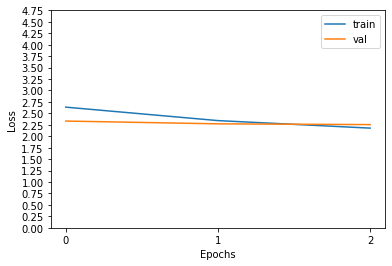

[Model] Model saved @ ./outputs/checkpoints

[Logs] Logs saved @ ./outputs/t5_finetuning_2022-08-04T13:02:34



In [ ]:
T5Trainer(train_dataset, val_dataset, source_text="input", target_text="question", model_params=model_params, output_dir=OUTPUT_DIR)

### Evaluation on test set

In [ ]:
from datasets import load_metric
rouge_metric = load_metric("rouge")
bleu_metric = load_metric('sacrebleu')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def evaluate(tokenizer, model, device, loader):

  """
  Function to get predictions from model

  """

  model.eval()
  sources = []
  predictions = []
  actuals = []
  results = []
  lengths = []
  with torch.no_grad():
      for _, data in tqdm(enumerate(loader)):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=25, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )

          # get words from ids
          srcs = [tokenizer.decode(i, skip_special_tokens=True, clean_up_tokenization_spaces=True) for i in ids]
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
          
          # track generated length 
          lengths += [len(t) for t in target]
          
          # if _%10==0:
          #     print(f'Completed {_}')

          sources.extend(srcs)
          predictions.extend(preds)
          actuals.extend(target)
      
  # Compute ROUGE scores and extract ROUGE f1 scores
  results = rouge_metric.compute(predictions=predictions, references=actuals, use_stemmer=True, use_aggregator=True)
  results = {key: value.mid.fmeasure * 100 for key, value in results.items()}
  # Compute BLEU scores
  scores = bleu_metric.compute(predictions=predictions, references=[[a] for a in actuals]) #note: BLEU expects references to be list of lists
  results["bleu_score"] = scores["score"]
  # Average generated output length
  results["gen_len"] = np.mean(lengths)

  results = {k: round(v, 4) for k, v in results.items()}
  return predictions, actuals, sources, results

In [ ]:
my_model_params={
    "MODEL_DIR":"./outputs/final/",            
    "VALID_BATCH_SIZE":8,          # evaluation batch size
    "MAX_SOURCE_TEXT_LENGTH":75,   # max length of source text
    "MAX_TARGET_TEXT_LENGTH":25,   # max length of target text
    "SEED": 42                     # set seed for reproducibility 

}

In [ ]:
def T5Evaluator(val_dataset, source_text, target_text, model_params, output_dir):
  
  """
  T5 evaluate

  """
   # for reproducibility
  torch.manual_seed(model_params["SEED"])
  np.random.seed(model_params["SEED"])
  torch.backends.cudnn.deterministic = True
  
  logging.info(f"""[Model]: Loading our finetuned model from directory {model_params["MODEL_DIR"]}...\n""")

  # encode text
  tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL_DIR"])

  # using T5 with language model layer
  model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL_DIR"])
  model = model.to(device)
  
  # create dataloaders
  test_qsd = QuestionSentenceDataset(val_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)

  val_params = {
      'batch_size': model_params["VALID_BATCH_SIZE"],
      'shuffle': False,
      'num_workers': 0
      }

  test_loader = DataLoader(test_qsd, **val_params)

  # evaluating test dataset
  logging.info(f"[Initiating Evaluation]...\n")
  predictions, actuals, sources, results = evaluate(tokenizer, model, device, test_loader)
  logging.info(f"[Performance on Test Set] {results}\n")
  print("Performance", results)
  final_df = pd.DataFrame({'generated':predictions,'actual':actuals, 'sentence': sources})
  final_df.to_csv(os.path.join(output_dir,'predictions.csv'))
  
  logging.info(f"[Evaluation Completed.]\n")
  print(f"""[Evaluation] Generated questions saved @ {os.path.join(output_dir,'predictions.csv')}\n""")

In [ ]:
T5Evaluator(test_dataset, source_text="input", target_text="question", model_params=my_model_params, output_dir=OUTPUT_DIR )

740it [08:36,  1.43it/s]


Performance {'rouge1': 32.6491, 'rouge2': 14.7086, 'rougeL': 29.7518, 'rougeLsum': 29.7411, 'bleu_score': 9.8088, 'gen_len': 61.1885}
[Evaluation] Generated questions saved @ ./outputs/predictions.csv



### Inference for single sample


In [ ]:
def infer(tokenizer, model, device, data):

  """
  Function to get predictions from model

  """

  model.eval()
  with torch.no_grad():
      ids = data['source_ids'].to(device, dtype = torch.long)
      mask = data['source_mask'].to(device, dtype = torch.long)

      generated_ids = model.generate(
          input_ids = ids,
          attention_mask = mask, 
          max_length=25, 
          num_beams=2,
          repetition_penalty=2.5, 
          length_penalty=1.0, 
          early_stopping=True
          )

      # get words from ids
      prediction = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
    
  return prediction

In [ ]:
def T5Inference(data, tokenizer, model, device, model_params):
  
  """
  T5 inference for a single sample
  """
  def text2input(source_text, MAX_SOURCE_TEXT_LENGTH=75): 
    # prepare data
    source_text = str(source_text)
    source_text = ' '.join(source_text.split())
    # from text to ids
    source = tokenizer.batch_encode_plus([source_text], max_length=MAX_SOURCE_TEXT_LENGTH, pad_to_max_length=True, 
                                         truncation=True, padding="max_length", return_tensors='pt')
    source_ids = source['input_ids'].squeeze().view(1, -1)
    source_mask = source['attention_mask'].squeeze().view(1, -1)
    
    return {'source_ids': source_ids.to(dtype=torch.long), 'source_mask': source_mask.to(dtype=torch.long)}

  # generate question
  input = text2input(data, model_params['MAX_SOURCE_TEXT_LENGTH'])
  print(input['source_ids'].shape)
  prediction = infer(tokenizer, model, device, input)
  return prediction

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

my_model_params = { "MODEL_DIR": "./outputs/final/", 
                   "MAX_SOURCE_TEXT_LENGTH": 75
                   } 

# encode text
tokenizer = T5Tokenizer.from_pretrained(my_model_params["MODEL_DIR"])

# using T5 with language model layer
model = T5ForConditionalGeneration.from_pretrained(my_model_params["MODEL_DIR"])
model = model.to(device)  

In [ ]:
# prepare input
answer = "Lorentz's Law"
sentence = "Through combining the definition of electric current as the time rate of change of electric charge, a rule of vector multiplication called Lorentz's Law describes the force on a charge moving in a magnetic field."
qg_input = f"answer: {answer} context: {sentence}"

# generate question
T5Inference(qg_input, tokenizer, model, device, my_model_params)

torch.Size([1, 75])


['combines the definition of electric current as the time rate of change of electric charge?']

In [ ]:
! zip final.zip /content/outputs/final/*

  adding: content/outputs/final/config.json (deflated 62%)
  adding: content/outputs/final/pytorch_model.bin (deflated 7%)
  adding: content/outputs/final/special_tokens_map.json (deflated 86%)
  adding: content/outputs/final/spiece.model (deflated 48%)
  adding: content/outputs/final/tokenizer_config.json (deflated 82%)
